# Variational Autoencoder (VAE)

In [1]:
from toolbox import format_time, showLoss, showLatent, showInterpolation
from torch.nn.functional import binary_cross_entropy as BCE
from torchvision.datasets import MNIST, FashionMNIST
from model import VAE_Linear, VAE_Conv2d
from torchsummary import summary
from tqdm.notebook import trange
from torch.optim.rmsprop import RMSprop
from torch import Tensor
from time import time
import numpy as np
from typing import Final
from numpy.typing import NDArray
import torch as tr

## Enabling cuda acceleration

In [2]:
assert tr.cuda.is_available(), "CUDA is strongly recommanded, otherwise change value of device to 'cpu'"
device = tr.device('cuda')
tr.manual_seed(196_883)
pass

## Loading and preprocessing data

$\large{X = \{x^1, x^2, \cdots, x^n\} }$

$\large{||X|| = (n,c,w,h)}$

- $n$ is the number of samples
- $c$ is the number of channels (1 $\rightarrow$ grayscale or 3 $\rightarrow$ RGB)
- $w$ is the width (in pixels) of the image
- $h$ is the height (in pixels) of the image

Color range has been normalized from $[0, 255]$ to $[0,1]$

For MNIST :

$\large{Y = \{0, \cdots, 9\}}$

$\large{||Y|| = n}$

### Dataset

In [3]:
# Vanilla MNIST

train, test = MNIST('./data', True, download = True), MNIST('./data', False)
#train, test = FashionMNIST('./data', True, download = True), FashionMNIST('./data', False)

transform = lambda im: im.type(tr.float32).reshape(im.shape[0], 1, 28, 28) / 255.0
X_train, y_train, X_test, y_test = transform(train.data), train.targets, transform(test.data), test.targets
del train, test, transform

print('min_width', min_width := 7)
print('nb_layers', nb_layers := 3)
print('on_device', on_device := True)

# Precreated datasets

#dataset_name: str = 'mnist'
#dataset_name: str = 'fashion_mnist'
#tl = lambda file_name: tr.load(f'Datasets/_binarynumpy/{dataset_name}/{file_name}.pt', weights_only = False)
#X_train, X_test, y_train, y_test = tl('train_fl'), tl('test_fl'), tl('train_y'), tl('test_y')

#print('min_width', min_width := 7)
#print('nb_layers', nb_layers := 3)
#print('on_device', on_device := True)

#dataset_name = 'celebA_32'
#dataset_name = 'celebA_64'
#dataset_name = 'celebA_128'
#tl = lambda file_name: tr.load(f'Datasets/_binarynumpy/{dataset_name}/{file_name}.pt', weights_only = False)
#X_train, X_test, y_train, y_test = tl('train_fl'), tl('test_fl'), None, None

#print('min_width', min_width := 4)
#print('nb_layers', nb_layers := int(np.log2(X_train.shape[-1])) - 1)
#print('on_device', on_device := False)

min_width 7
nb_layers 3
on_device True


## Hyper-parameters

In [4]:
print('||X|| =', old_shape := X_train.shape)
print('output_shape', output_shape := np.asarray((*old_shape[2:], old_shape[1])))
assert min_width * 2**(nb_layers - 1) == output_shape[0], 'Incorrect min_width & nb_layers settings'
print('input_dim', input_dim := output_shape.prod())
if on_device:
    X_train, X_test = X_train.to(device), X_test.to(device)

print('batch_size', batch_size := 2**6)
print('lr', lr := 1e-3)
print('is_linear', is_linear := False)
if is_linear:
    X_train, X_test = X_train.view(X_train.size(0), input_dim), X_test.view(X_test.size(0), input_dim)
else:
    print('kernel_size', kernel_size := 5)

print('min_weight', min_weight := 6)
# Growing number of features/weights
print('weights', weights := [2**i for i in range(min_weight, min_weight + nb_layers)])
# Static number of features/weights
# print('weights', weights := [2**min_weight for i in range(nb_layers)])

||X|| = torch.Size([60000, 1, 28, 28])
output_shape [28 28  1]
input_dim 784
batch_size 64
lr 0.001
is_linear False
kernel_size 5
min_weight 6
weights [64, 128, 256]


## Building model

### Probabilistic encoder

$\large{q_\phi(Z|X)}$

#### Reparametrization trick

$\large{z = \mu + \sigma \odot \epsilon}$

$\large{\epsilon \sim \mathcal{N}(\mu_x, \sigma_x)}$

In [5]:
def reparameterize(mu: Tensor, log_var: Tensor) -> Tensor:
    std: Final[Tensor] = log_var.mul(0.5).exp_()
    eps: Final[Tensor] = std.data.new(std.size()).normal_()
    return eps.mul(std).add_(mu)

### Probabilistic decoder

$\large{\mathcal{p}_\theta(X|Z)}$

## Criterion (loss function)

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = D_{KL}(q_\phi(Z|X)||p_\theta(Z|X))}$$

Because $\large{D_{KL}(A||B)}$ = $\large{\int\limits_{-\infty}^\infty A(x) \cdot log\frac{A(x)}{B(x)}dx}$

$$\large{= \int q_\phi(Z|X) \cdot log\frac{q_\phi(Z|X)}{p_\theta(Z|X)}dz}$$

Because $\large{p(Z|X) = \frac{p(Z,X)}{p(Z)}}$

$$\large{= \int q_\phi(Z|X) \cdot log\frac{q_\phi(Z|X) \cdot p_\theta(X)}{p_\theta(Z,X)}dz}$$

$$\large{= \int q_\phi(Z|X) \cdot [log(p_\theta(X) + log \frac{q_\phi(Z|X)}{p_\theta(Z,X)}]dz}$$

Because $\large{\int q(Z|X)dz=1}$

$$\large{= log[p_\theta(X)] + \int q_\phi(Z|X) \cdot log \frac{q_\phi(Z|X)}{p_\theta(Z,X)}dz}$$

$$\large{= log[p_\theta(X)] + \int q_\phi(Z|X) \cdot log \frac{q_\phi(Z|X)}{p_\theta(X|Z) \cdot p_\theta(Z)}dz}$$

Because $\large{p(z,x)=p(x|z) \cdot p(z)}$

$$\large{= log[p_\theta(X)] + E_{z\sim q_\phi(Z|X)}[log \frac{q_\phi(Z|X)}{p_\theta(Z)} - log(p_\theta(X|Z))]}$$

$$\large{= log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))- E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)]}$$

### Rearranging terms

$$\large{D_{KL}(q_\phi(Z|X)||p_\theta(Z|X)) = log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))- E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)]}$$

$$\large{log[p_\theta(X)] - D_{KL}(q_\phi(Z|X)||p_\theta(Z|X)) = E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)] - D_{KL}(q_\phi(Z|X)||p_\theta(Z))}$$

The LHS of the equation is what we want to maximize when learning the true distributions, soo the negation of the above defines our loss function :

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = - log[p_\theta(X)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z|X))}$$

$$\large{ = - E_{z\sim q_\phi(Z|X)} log[p_\theta(X|Z)] + D_{KL}(q_\phi(Z|X)||p_\theta(Z))}$$

$$\large{\theta^*,\phi^* = argmin_{\theta,\phi}(\mathcal{L_{VAE}})}$$

### Final form (derived)

With

$$\large{BCE = - E_{z\sim q_\phi(Z|X)}[p_\theta(X|Z)]}$$

$$\large{\mathcal{L_{VAE}}(\theta,\phi) = BCE + D_{KL} (q_\phi(Z|X)||p_\theta(Z))}$$

In [6]:
def criterion(output: Tensor, mu: Tensor, log_var: Tensor, x_batch: Tensor,
              batch_size: int, input_dim: int) -> Tensor:
    D_KL: Tensor = -0.5 * tr.sum(1 + log_var - mu.pow(2) - log_var.exp())
    D_KL /= batch_size * input_dim
    return BCE(output, x_batch) + D_KL

## Creating the model

In [7]:
if is_linear:
    model: Final = VAE_Linear(reparameterize, weights, device, input_dim = input_dim)
    summary(model, (1, input_dim), batch_size, device = device.type)
else:
    model: Final = VAE_Conv2d(reparameterize, weights, device, output_shape, kernel_size, min_width)
    summary(model, tuple(output_shape[::-1]), batch_size, device = device.type)
optimizer: Final = RMSprop(model.parameters(), lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 14, 14]           1,664
            Conv2d-2           [64, 64, 14, 14]               0
              ReLU-3           [64, 64, 14, 14]               0
          Conv2d_R-4           [64, 64, 14, 14]               0
            Conv2d-5            [64, 128, 7, 7]         204,928
            Conv2d-6            [64, 128, 7, 7]               0
              ReLU-7            [64, 128, 7, 7]               0
          Conv2d_R-8            [64, 128, 7, 7]               0
            Conv2d-9            [64, 256, 4, 4]         819,456
           Conv2d-10            [64, 256, 4, 4]               0
             ReLU-11            [64, 256, 4, 4]               0
         Conv2d_R-12            [64, 256, 4, 4]               0
          Flatten-13                 [64, 4096]               0
           Linear-14                   

## Training the model

In [8]:
def train(X_train: Tensor, X_test: Tensor, nb_epoch: int, show_loss_interval: int) -> dict[str, NDArray[np.float32]]:
    hist: dict[str, NDArray[np.float32]] = {f'{name}_loss': np.empty(nb_epoch, dtype = np.float32) for name in ['train', 'test']}
    last_time: float = time()
    total_time_spent: float = 0.0
    n_train_batches, n_test_batches = np.ceil(X_train.shape[0] / batch_size).astype(np.uint64), np.ceil(X_test.shape[0] / batch_size).astype(np.uint64)

    model.train()
    print('Beginning of training')
    for epoch in trange(1, nb_epoch + 1, position = 0, desc = 'Epoch', leave = False):
        batch_loss: float = 0.0
        for batch_idx in trange(0, n_train_batches, position = 1, desc = 'Batch train', leave = False):
            X_batch: Tensor = X_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            if not on_device:
                X_batch = X_batch.to(device)
            model.zero_grad()
            output, mu, log_var = model(X_batch)
            loss: Tensor = criterion(output, mu, log_var, X_batch, batch_size, input_dim)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
            if not on_device:
                del X_batch

        hist['train_loss'][epoch - 1] = batch_loss / n_train_batches

        batch_loss: float = 0.0
        for batch_idx in trange(0, n_test_batches, position = 1, desc = 'Batch test', leave = False):
            X_batch: Tensor = X_test[batch_idx * batch_size: (batch_idx + 1) * batch_size]
            if not on_device:
                X_batch = X_batch.to(device)
            output, mu, log_var = model(X_batch)
            loss: Tensor = criterion(output, mu, log_var, X_batch, batch_size, input_dim)
            batch_loss += loss.item()
            if not on_device:
                del X_batch

        hist['test_loss'][epoch - 1] = batch_loss / n_test_batches

        if epoch % show_loss_interval == 0:
            time_spent: float = time() - last_time
            last_time += time_spent
            total_time_spent += time_spent
            print(f'Epoch {epoch:04d} == {hist['train_loss'][epoch - 1]:.5f}', end = ' | ')
            print(f'{hist['test_loss'][epoch - 1]:.5f}', end = ' - ')
            print(format_time(time_spent))

    print(f'Ending of training, spent {format_time(total_time_spent)} training')
    model.eval()
    return hist

In [9]:
hist = train(X_train, X_test, 50, 10)

Beginning of training


Epoch 0050 == 0.17520 | 0.18702 - 1m 46s 620ms
Ending of training, spent 9m 4s 51ms training


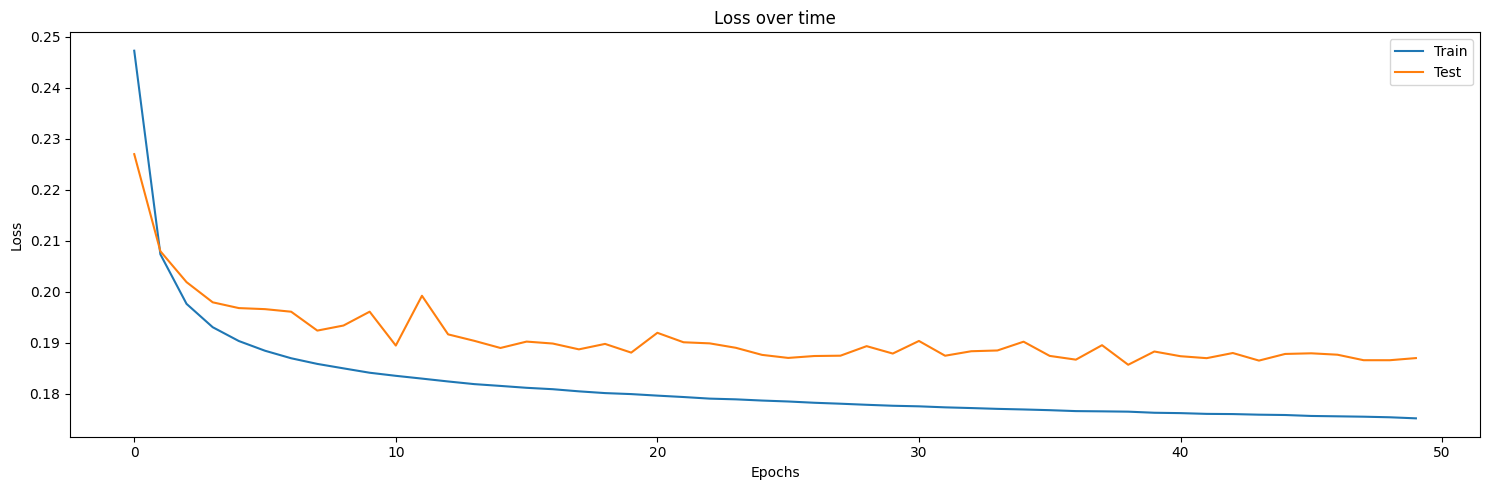

In [10]:
showLoss(hist)

## Latent space

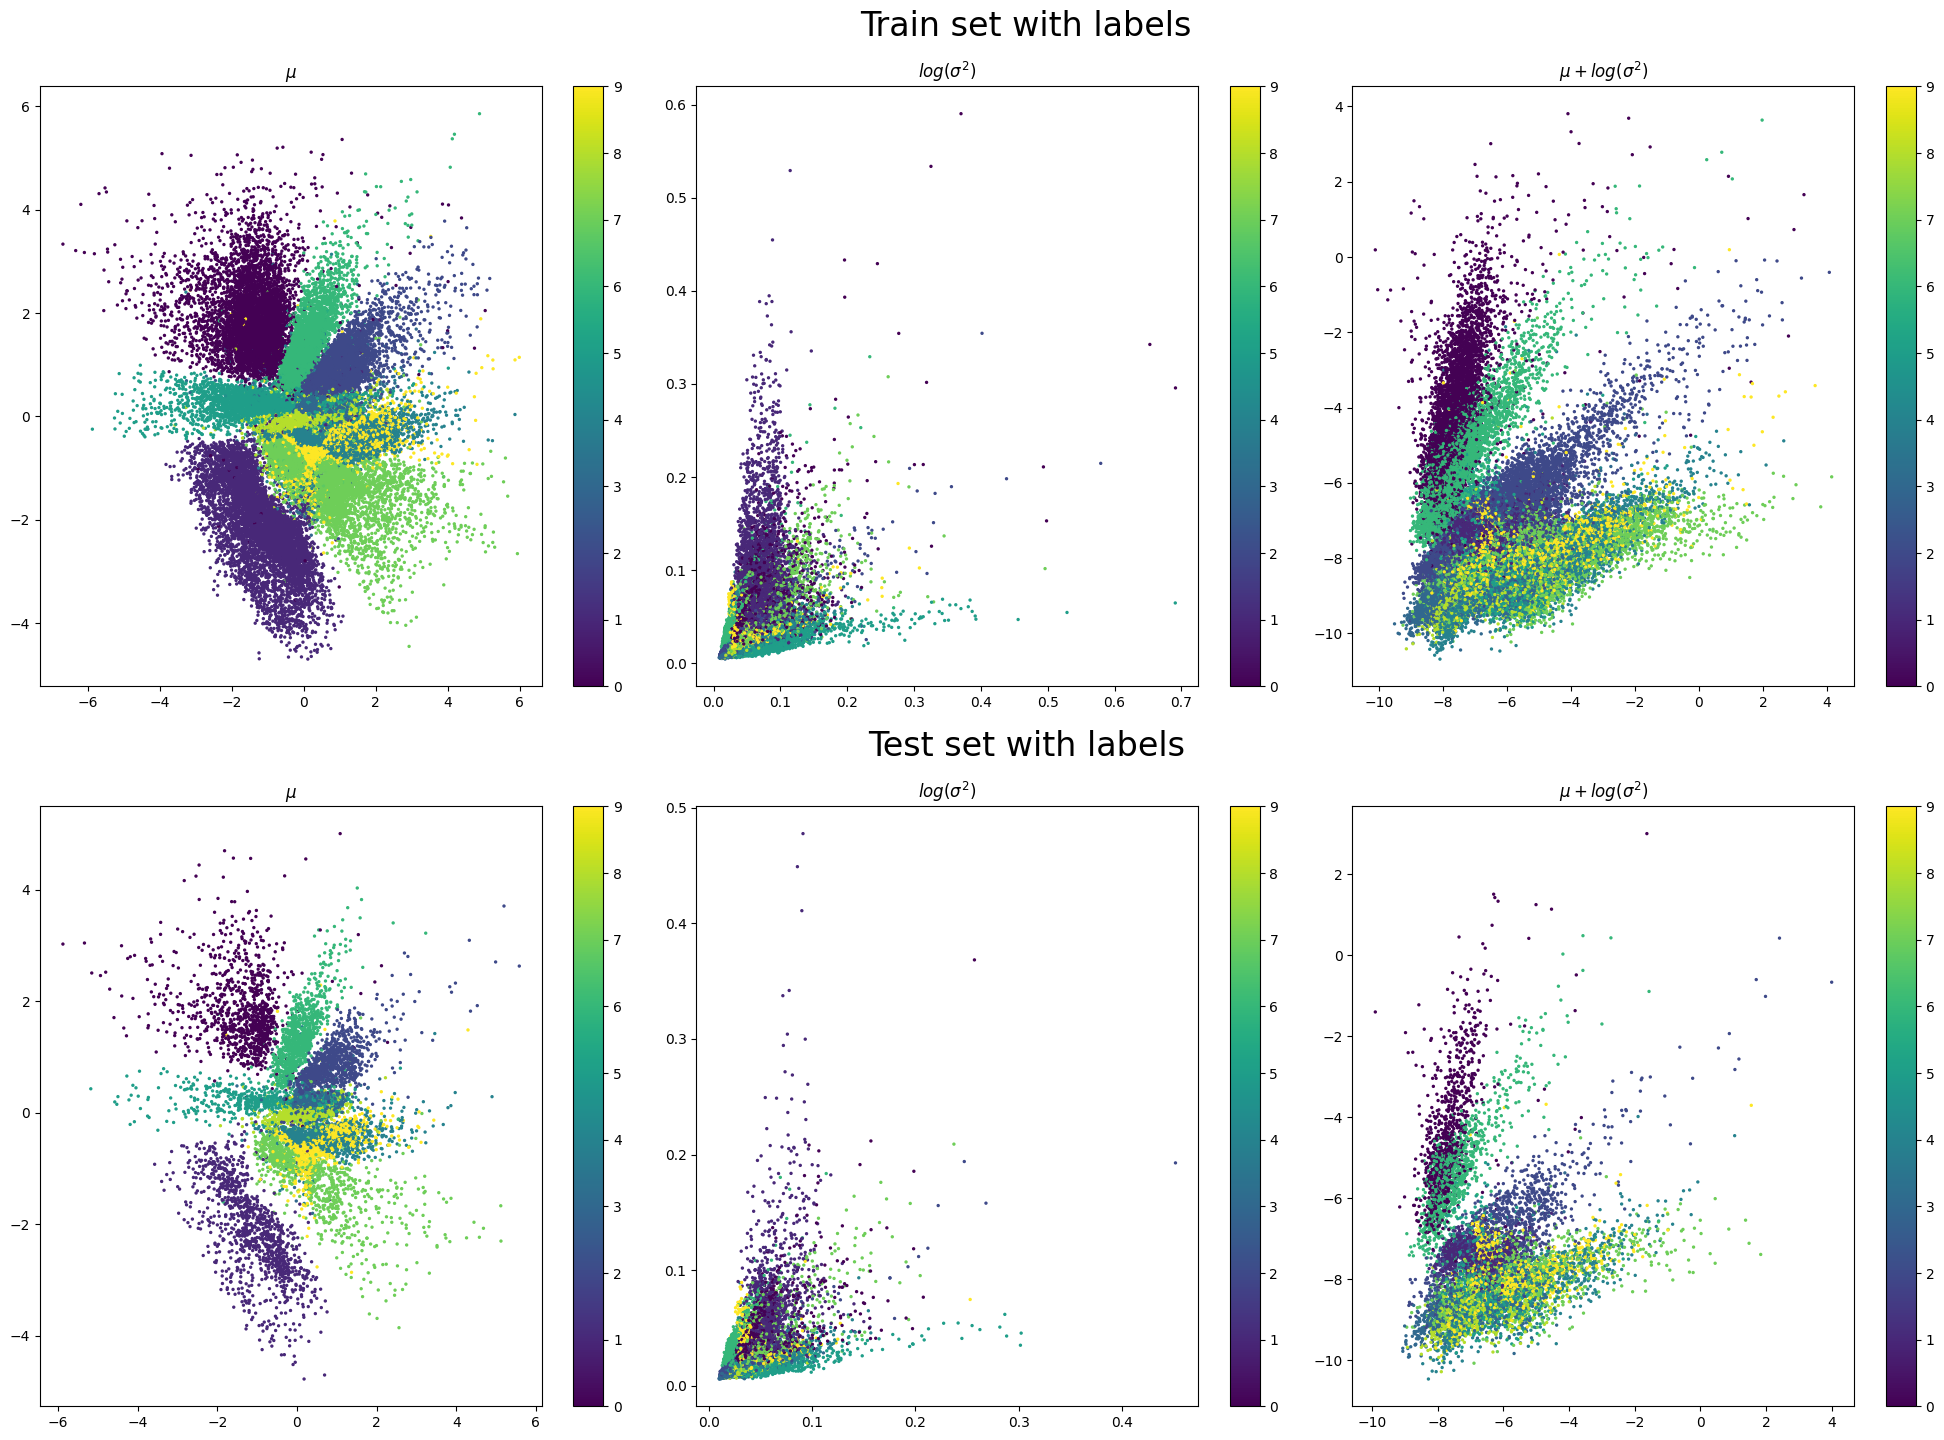

In [11]:
t_mu, t_log_var, t_mu_log_var = showLatent(model, X_train, X_test, batch_size, y_train, y_test,
                                           device if not on_device else None)

## Linear interpolation

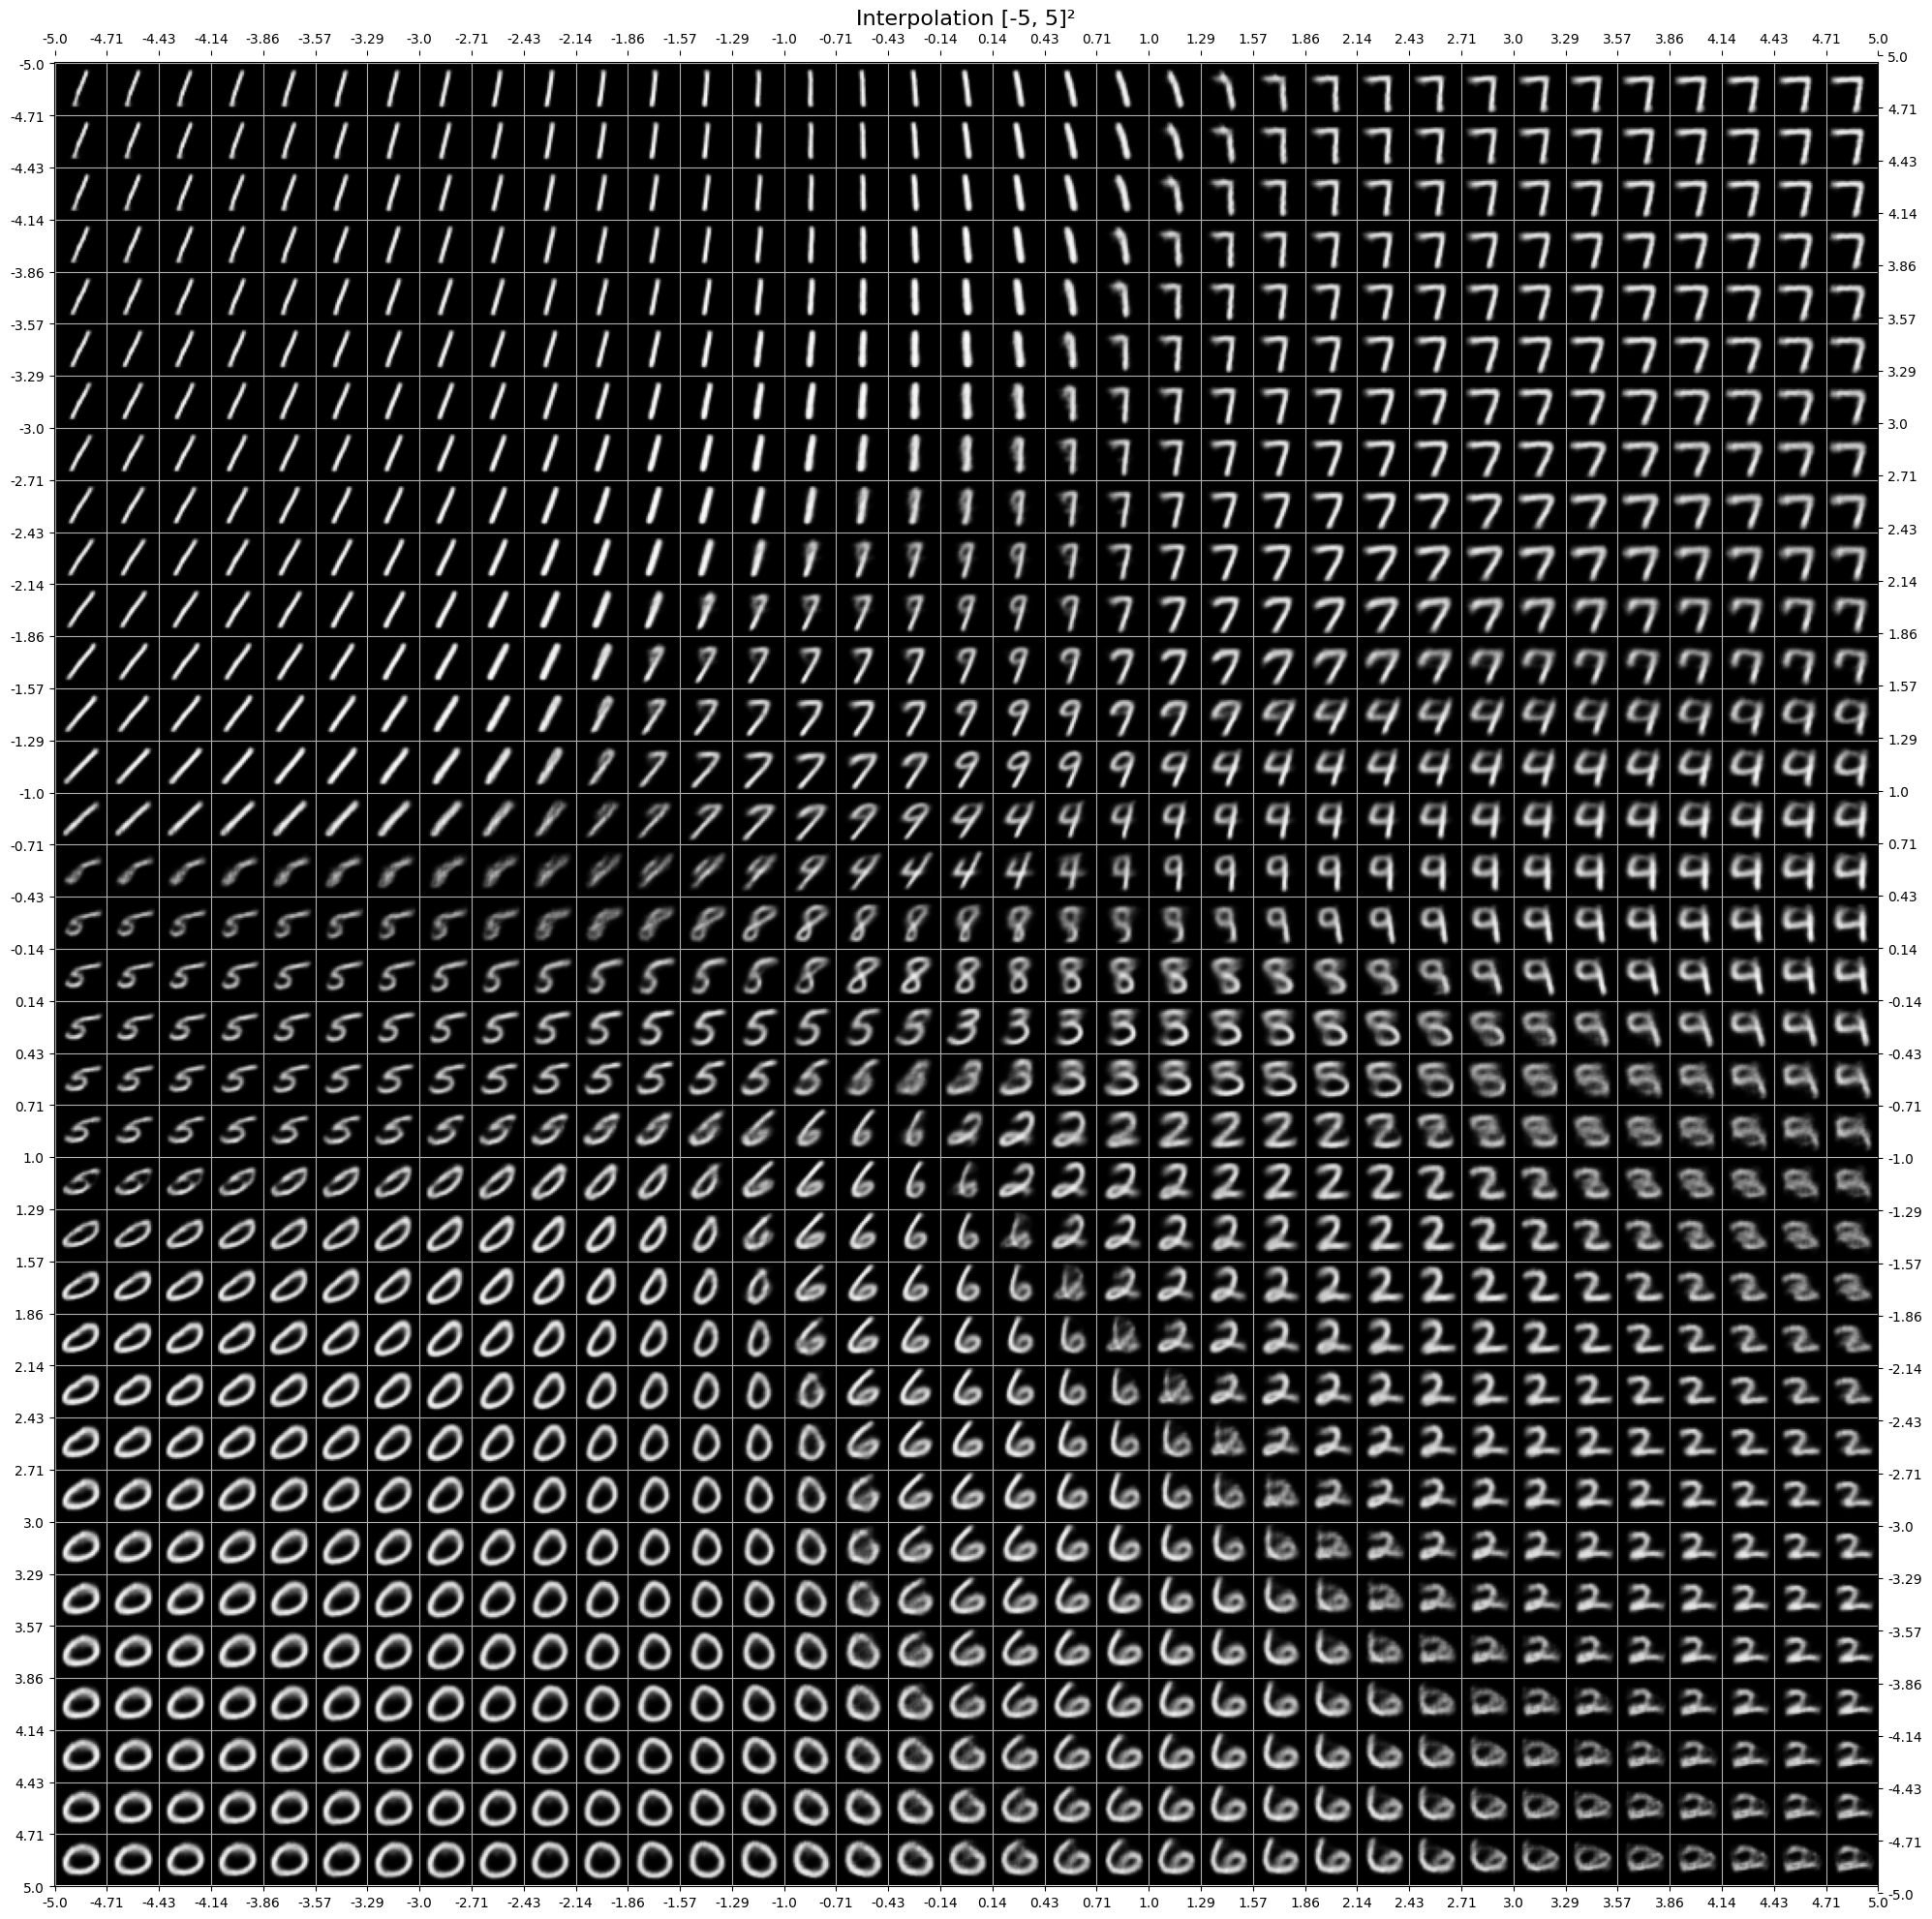

In [12]:
showInterpolation(model, output_shape, device, 35, (-5, 5))

_2021 Pierre Saunders @saundersp_